In [2]:
from sklearn.metrics import f1_score
import numpy as np
import random
file_path = 'D:\\.Mtech\\2mtech 2nd sem\\NLP\\assignment\\ass 1\\Brown_train.txt'  
with open(file_path, 'r') as file:
    text_content = file.read()

In [3]:
# Split the content into lines
lines = text_content.strip().split('\n')

# Initialize a list to store word-tag pairs
pairs = []

# Parse each line to extract word-tag pairs
for line in lines:
    # Split the line into words and tags
    words_tags = line.strip().split()
    # Extract word-tag pairs and add them to the list
    for word_tag in words_tags:
        parts = word_tag.split('/')
        if len(parts) == 2:
            word, tag = parts
            pairs.append([word, tag])

# Shuffle the data
random.shuffle(pairs)

In [4]:
# pairs

In [5]:
# Split data into training and testing sets
train_size = int(len(pairs) * 0.8)
train, test = pairs[:train_size], pairs[train_size:]

In [6]:
# Extract unique words and tags
unique_words = set(word for word, _ in pairs)
unique_tags = set(tag for _, tag in pairs)

In [7]:
unique_tags

{'.',
 'ADJ',
 'ADP',
 'ADV',
 'CONJ',
 'DET',
 'NOUN',
 'NUM',
 'PRON',
 'PRT',
 'VERB',
 'X'}

In [8]:
# Mapping words and tags to numbers
word_to_number = {word: i for i, word in enumerate(unique_words)}
word_to_number['<UNK>'] = len(word_to_number)  # Add '<UNK>' token to the dictionary
number_to_word = {i: word for word, i in word_to_number.items()}
tag_to_number = {tag: i for i, tag in enumerate(unique_tags)}
number_to_tag = {i: tag for tag, i in tag_to_number.items()}

In [9]:
#  word_to_number
#  number_to_word
#  tag_to_number
# number_to_tag


In [10]:
# Initialize transition, emission, and initial probability matrices
num_tags = len(unique_tags)
num_words = len(unique_words)
pi = np.ones(num_tags, dtype=float)
A = np.ones((num_tags, num_tags), dtype=float)
B = np.ones((num_tags, num_words), dtype=float)

In [11]:
# Initialize prev_tag
prev_tag = None

# Train the HMM model
for word, tag in train:
    pi[tag_to_number[tag]] += 1
    if len(word) > 0:
        B[tag_to_number[tag]][word_to_number.get(word, word_to_number['<UNK>'])] += 1

    if prev_tag is not None:
        A[tag_to_number[prev_tag]][tag_to_number[tag]] += 1
    prev_tag = tag

In [12]:
# Normalize probabilities
pi /= pi.sum()
A /= A.sum(axis=1, keepdims=True)
B /= B.sum(axis=1, keepdims=True)

In [13]:
# Viterbi algorithm for decoding
def viterbi(sentence):
    num_tags = len(tag_to_number)
    num_words = len(word_to_number)
    
    # Initialize delta and psi matrices
    delta = np.zeros((len(sentence), num_tags))
    psi = np.zeros((len(sentence), num_tags), dtype=int)
    
    # Initialization step
    for tag in range(num_tags):
        word_idx = word_to_number.get(sentence[0], None)
        if word_idx is None:
            # Handle unknown words by assigning a default index
            word_idx = word_to_number['<UNK>']
        delta[0, tag] = pi[tag] * B[tag, word_idx]

    # Recursion step
    for t in range(1, len(sentence)):
        word_idx = word_to_number.get(sentence[t], None)
        if word_idx is None:
            # Handle unknown words by assigning a default index
            word_idx = word_to_number['<UNK>']
        for curr_tag in range(num_tags):
            delta[t, curr_tag] = np.max(delta[t-1] * A[:, curr_tag]) * B[curr_tag, word_idx]
            psi[t, curr_tag] = np.argmax(delta[t-1] * A[:, curr_tag])

    # Backtracking step
    best_path = [np.argmax(delta[-1])]
    for t in range(len(sentence) - 1, 0, -1):
        best_path.append(psi[t, best_path[-1]])
    best_path.reverse()

    return [number_to_tag[tag] for tag in best_path]

In [14]:
# Test the model
y_true = [tag for _, tag in test]
y_pred = [viterbi(sentence.split()) for sentence, _ in test]
# Flatten the predicted sequences
y_pred_flat = [tag for seq in y_pred for tag in seq]

In [15]:
y_true[:10]

['VERB', '.', 'NOUN', 'PRON', 'NOUN', 'NOUN', 'DET', 'ADP', 'ADP', 'DET']

In [16]:
y_pred_flat[:10]

['VERB', '.', 'NOUN', 'PRON', 'NOUN', 'NOUN', 'DET', 'ADP', 'ADP', 'DET']

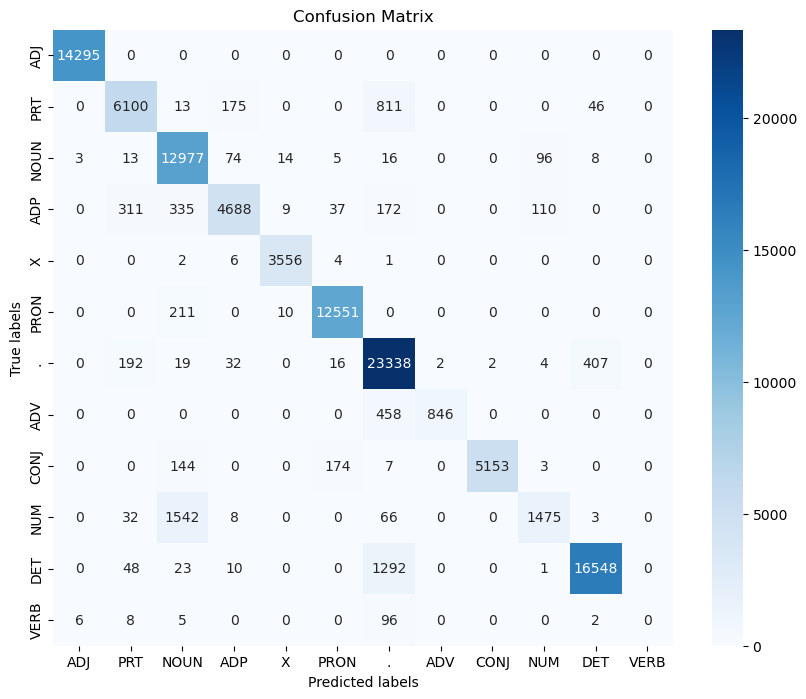

In [17]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Compute the confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred_flat)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=unique_tags, yticklabels=unique_tags)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

In [22]:
# Calculate F1 score
f1_macro = f1_score(y_true, y_pred_flat, average='macro')
f1_micro = f1_score(y_true, y_pred_flat, average='micro')

print("F1 Score (Macro):", f1_macro)
print("F1 Score (Micro):", f1_micro)

F1 Score (Macro): 0.8242848000542744
F1 Score (Micro): 0.9347764038633287
